###### Multiple Linear Regression
## Housing Case Study


###### Step 1: Reading and Understanding the Data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [16]:
# reading the dataset
company = pd.read_csv("train.csv")

In [17]:
# summary of the dataset: 1460 rows, 81 columns
print(company.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [18]:
company.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Step 2: Data Cleaning

In [19]:
#Check the number of null values in the columns

company.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [20]:
# summing up the missing values (column-wise)
round(100*(company.isnull().sum()/len(company.index)), 2)

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
                 ...  
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
SalePrice         0.00
Length: 81, dtype: float64

In [21]:
company = company.drop('PoolQC', axis=1) ##65 % Missing
company = company.drop('Fence', axis=1) ##93 % Missing
company = company.drop('MiscFeature', axis=1) ##98 % Missing
company = company.drop('FireplaceQu', axis=1) ##34% Missing
company = company.drop('Alley', axis=1) 
company = company.drop('LotFrontage', axis=1) 

In [22]:
company = company.drop('Id', axis=1)

In [23]:
# summing up the missing values (column-wise)
round(100*(company.isnull().sum()/len(company.index)), 2)

MSSubClass       0.0
MSZoning         0.0
LotArea          0.0
Street           0.0
LotShape         0.0
                ... 
MoSold           0.0
YrSold           0.0
SaleType         0.0
SaleCondition    0.0
SalePrice        0.0
Length: 74, dtype: float64

In [24]:
company.shape

(1460, 74)

###### from 81 columns to 75 columns after removing those

In [25]:
# Dropping rows for the NaN values since we will still have sufficient data for analysis
company.dropna(axis='rows', inplace=True)

In [26]:
company.shape

(1338, 74)

In [27]:
1338/1460

0.9164383561643835

###### only 9 percent of total results are removed so we can go ahead with this approach

In [28]:
company.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,...,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,56.136024,10706.294469,6.219731,5.596413,1973.029148,1985.668909,110.360239,464.234679,49.218236,582.494768,...,99.384903,47.782511,21.263827,3.585949,16.43423,3.010463,42.932735,6.331839,2007.805680,186761.782511
std,41.252576,10336.621126,1.324472,1.078124,29.563540,20.296463,185.604816,458.792420,166.196584,439.950528,...,127.537065,65.362562,60.843964,30.224622,58.05159,41.961337,508.056255,2.699437,1.330691,78913.847668
min,20.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,7744.000000,5.000000,5.000000,1956.000000,1968.000000,0.000000,0.000000,0.000000,248.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.000000,2007.000000,135000.000000
50%,50.000000,9600.000000,6.000000,5.000000,1976.000000,1994.500000,0.000000,413.000000,0.000000,489.000000,...,6.000000,28.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000,2008.000000,168500.000000
75%,70.000000,11760.750000,7.000000,6.000000,2001.000000,2004.000000,174.000000,733.000000,0.000000,815.750000,...,174.500000,70.000000,0.000000,0.000000,0.00000,0.000000,0.000000,8.000000,2009.000000,220000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.00000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


###### Step 2: Visualising the Data

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:

# Creating derived features
# Converting dates (YearBuilt, YearRemodAdd, GarageYrBlt) to days (DiffYearBuilt, DiffYearRemodAdd, DiffGarageYrBlt) from today
company['DiffYearBuilt'] = pd.datetime.now().year - company['YearBuilt']
company['DiffYearRemodAdd'] = pd.datetime.now().year - company['YearRemodAdd']
company['DiffGarageYrBlt'] = pd.datetime.now().year - company['GarageYrBlt']

In [32]:
company.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [33]:
company.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 

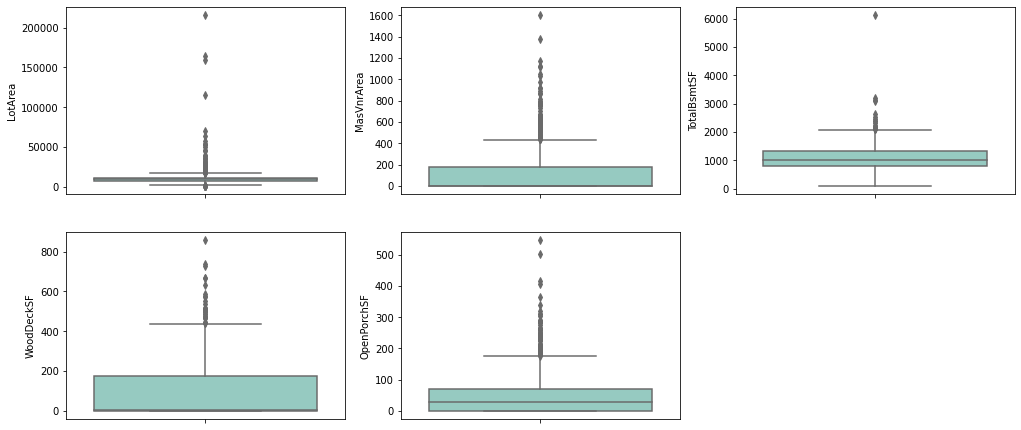

In [34]:
# Check the outliers in all the numeric columns

plt.figure(figsize=(17, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', palette='Set3', data = company)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', palette='Set3', data = company)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', palette='Set3', data = company)
plt.subplot(5,3,4)
sns.boxplot(y = 'WoodDeckSF', palette='Set3', data = company)
plt.subplot(5,3,5)
sns.boxplot(y = 'OpenPorchSF', palette='Set3', data = company)
plt.show()

In [35]:
# Caping Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = company['LotArea'].quantile(0.98)
company = company[company["LotArea"] < nn_quartile_LotArea]

# Removing values beyond 98% for MasVnrArea

nn_quartile_MasVnrArea = company['MasVnrArea'].quantile(0.98)
company = company[company["MasVnrArea"] < nn_quartile_MasVnrArea]

# Removing values beyond 99% for TotalBsmtSF

nn_quartile_TotalBsmtSF = company['TotalBsmtSF'].quantile(0.99)
company = company[company["TotalBsmtSF"] < nn_quartile_TotalBsmtSF]

# Removing values beyond 99% for WoodDeckSF

nn_quartile_WoodDeckSF = company['WoodDeckSF'].quantile(0.99)
company = company[company["WoodDeckSF"] < nn_quartile_WoodDeckSF]

# Removing values beyond 99% for OpenPorchSF

nn_quartile_OpenPorchSF = company['OpenPorchSF'].quantile(0.99)
company = company[company["OpenPorchSF"] < nn_quartile_OpenPorchSF]

In [36]:
company.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DiffYearBuilt,DiffYearRemodAdd,DiffGarageYrBlt
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,2,2008,WD,Normal,208500,18,18,18.0
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,5,2007,WD,Normal,181500,45,45,45.0
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,9,2008,WD,Normal,223500,20,19,20.0
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,2,2006,WD,Abnorml,140000,106,51,23.0
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,12,2008,WD,Normal,250000,21,21,21.0


In [37]:
##Drop the following columns that have more than 85% values associated to a specific value

# Method to get the column names that have count of one value more than 85%

def getHighCategoricalValueCounts():
    column = []
    categorical_columns = company.select_dtypes(include=['object'])
    for col in (categorical_columns):
        if(company[col].value_counts().max() >= 1241):
            column.append(col)
    return column

columnsToBeRemoved = getHighCategoricalValueCounts()

# Remove the columns with skewed data

company.drop(columnsToBeRemoved, axis = 1, inplace = True)

company.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DiffYearBuilt,DiffYearRemodAdd,DiffGarageYrBlt
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,2,2008,WD,Normal,208500,18,18,18.0
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,0,0,5,2007,WD,Normal,181500,45,45,45.0
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,9,2008,WD,Normal,223500,20,19,20.0
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,0,0,2,2006,WD,Abnorml,140000,106,51,23.0
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,0,0,12,2008,WD,Normal,250000,21,21,21.0


In [38]:
# Separating numerical and categorical fields for analysisng them separately using the provided Data Dictionary.

# OUTCOME COLUMN:
out_col = 'SalePrice'

# NUMERICAL COLUMNS: 
num_col = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
           'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
           'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
           'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'DiffYearBuilt', 'DiffYearRemodAdd',
           'DiffGarageYrBlt']
print(len(num_col))

# CATEGORICAL COLUMNS: 
cat_col = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
           'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
           'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
           'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
           'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 
           'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
print(len(cat_col))


30
41


In [39]:
# Function for Analysis of Numerical column
def num_col_analysis(i, col_i,col_o):
    plt.figure(i)
    plt.figure(figsize=(15,8))
    sns.jointplot(x=col_i, y=col_o, data=company[[col_i,col_o]])
    plt.show()

In [40]:

# Function for Analysis of Categorical column
def cat_col_analysis(i, col_i,col_o):
    plt.figure(i)
    variables = company[[col_i]].nunique()
    plt.figure(figsize=(variables,variables/1.77))
    my_order = company[[col_i,col_o]].groupby(by=[col_i])[col_o].median().sort_values(ascending=True)
    sns.boxplot(x=col_i, y=col_o, data=company[[col_i,col_o]], order=my_order.index)

### Step 3: Data Visualization

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

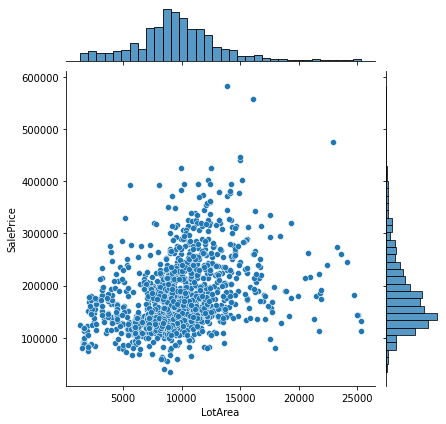

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

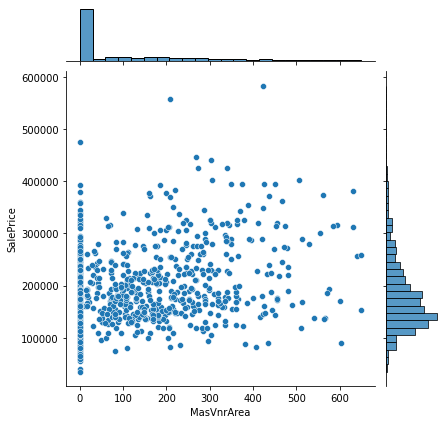

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

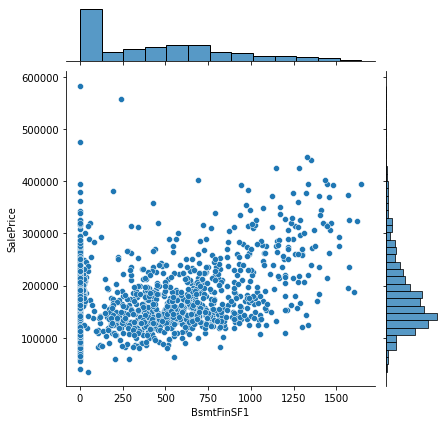

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

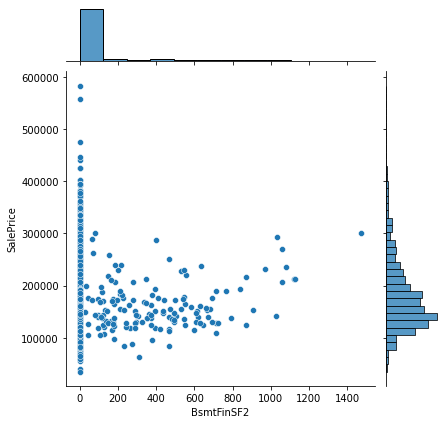

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

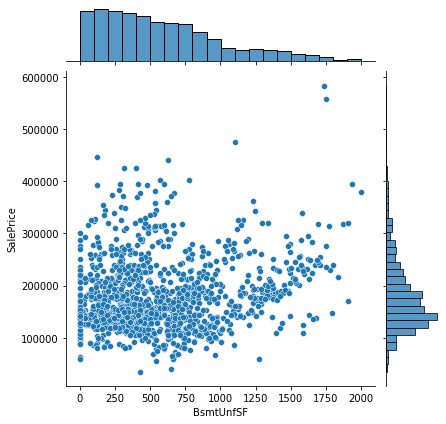

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

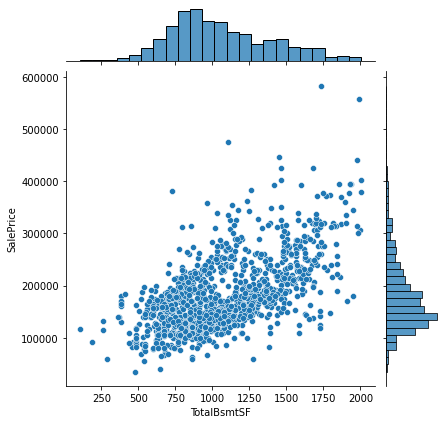

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

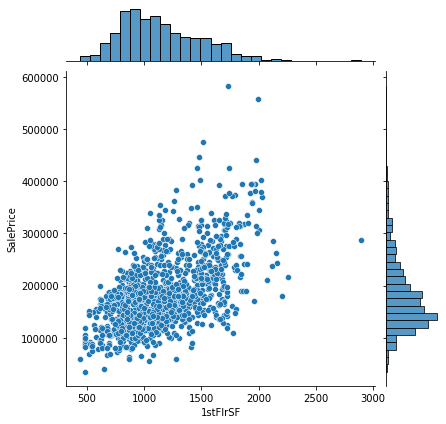

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

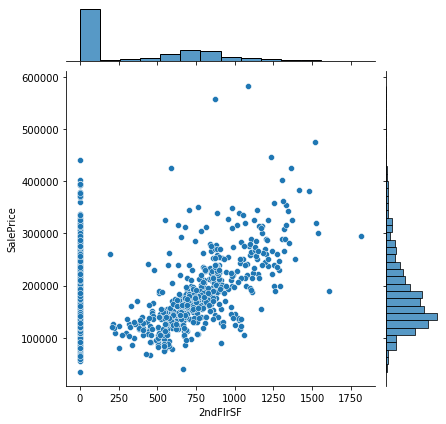

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

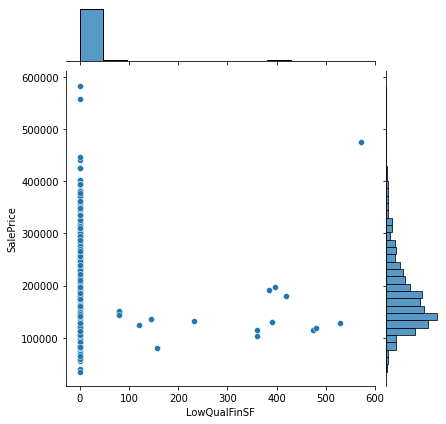

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

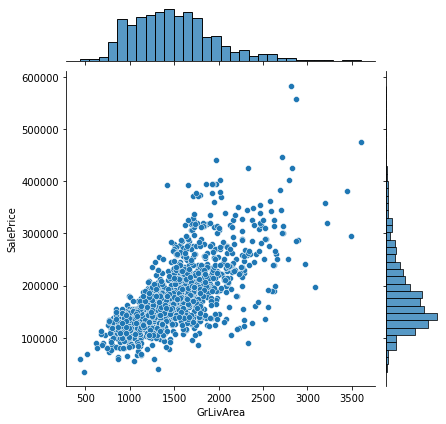

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

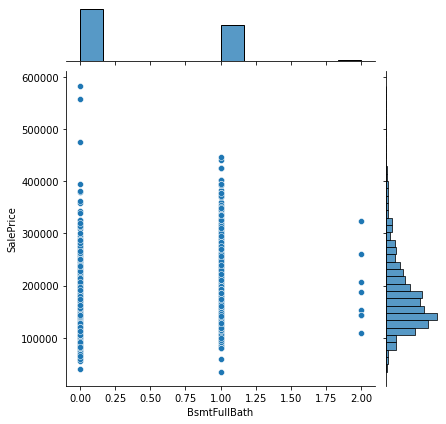

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

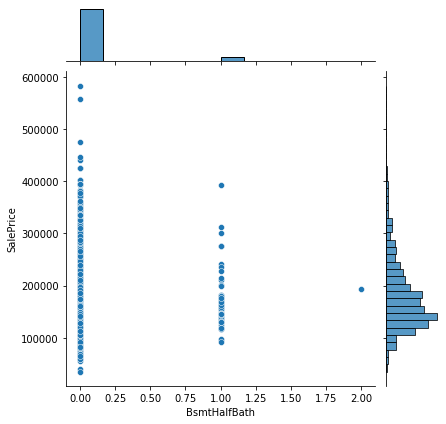

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

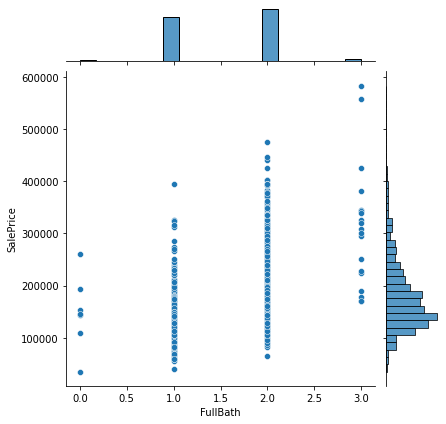

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

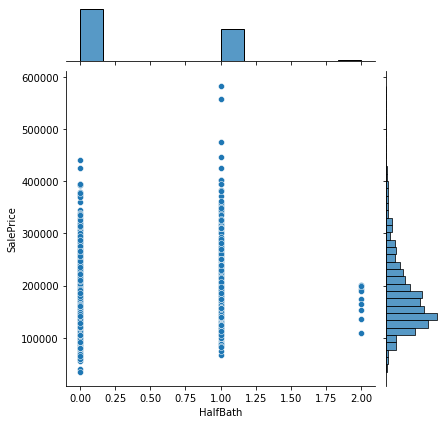

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

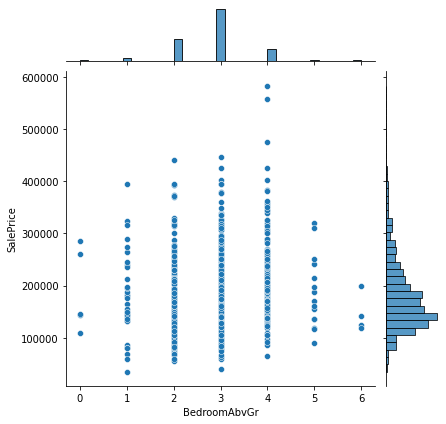

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

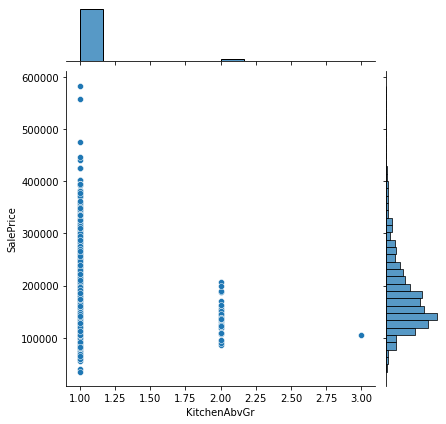

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

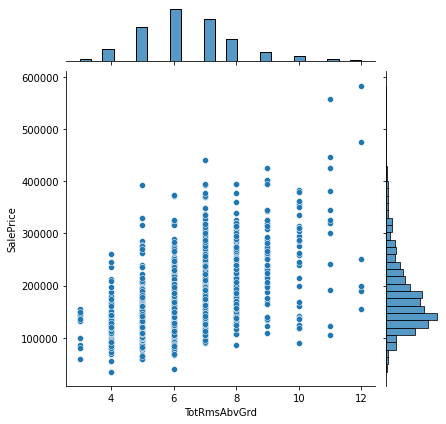

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

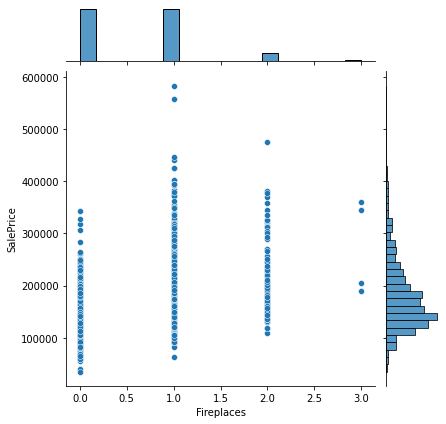

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

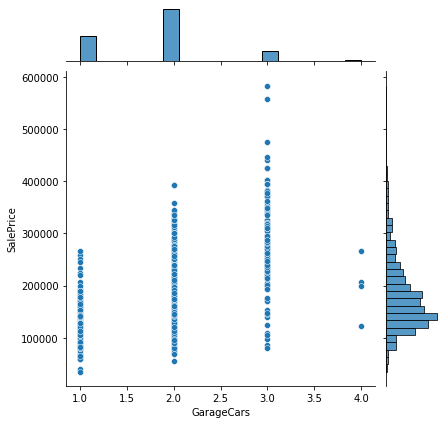

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

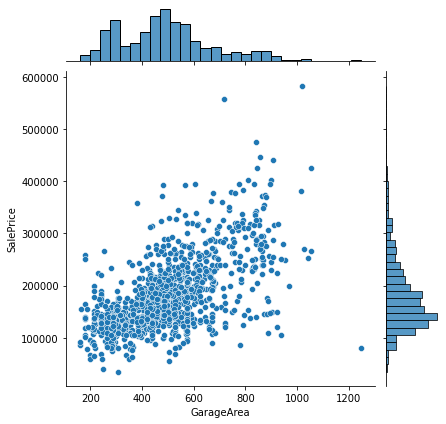

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

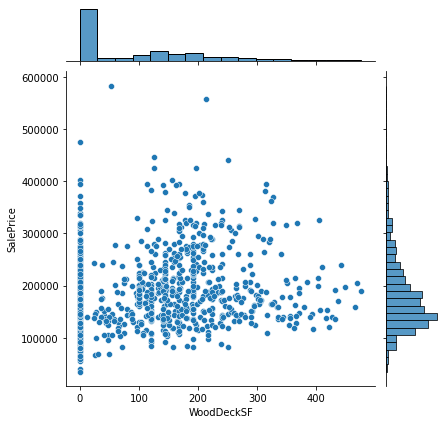

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

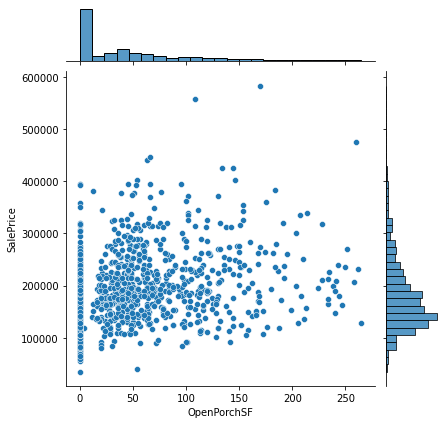

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

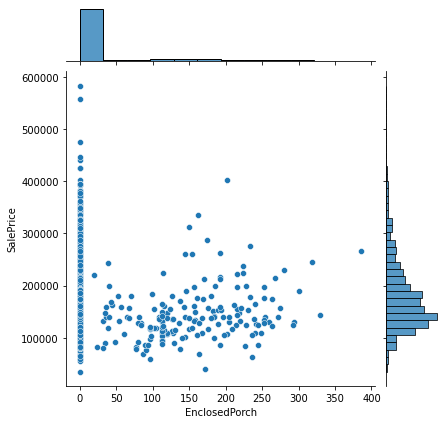

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

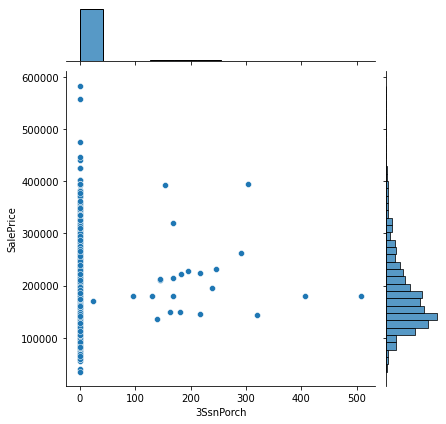

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

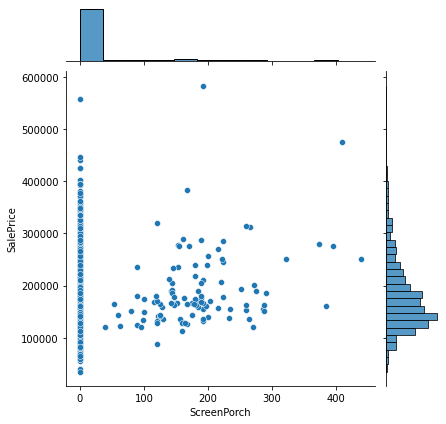

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

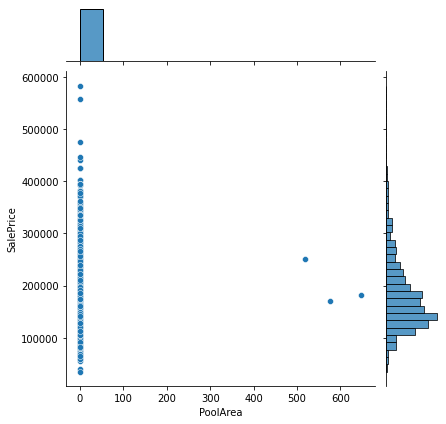

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

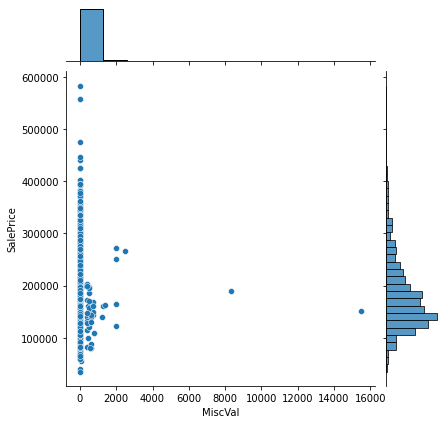

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

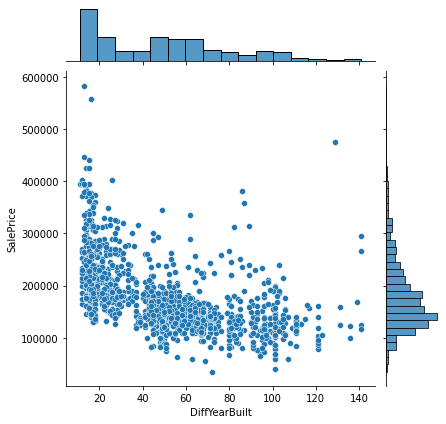

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

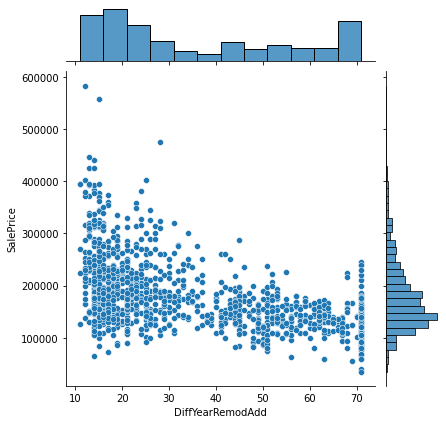

<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

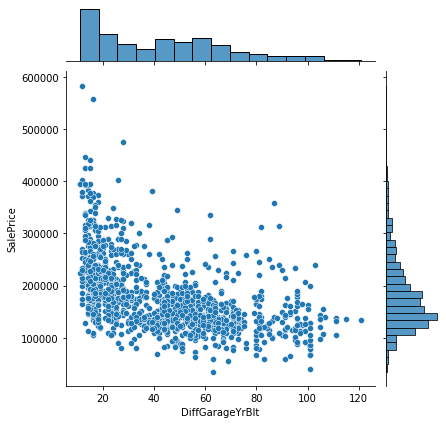

In [41]:

# NUMERICAL COLUMN ANALYSIS
for i, col in enumerate(num_col):
    num_col_analysis(i, col, out_col)

###### There are co relation that exist between most of the variables

<Figure size 432x288 with 0 Axes>

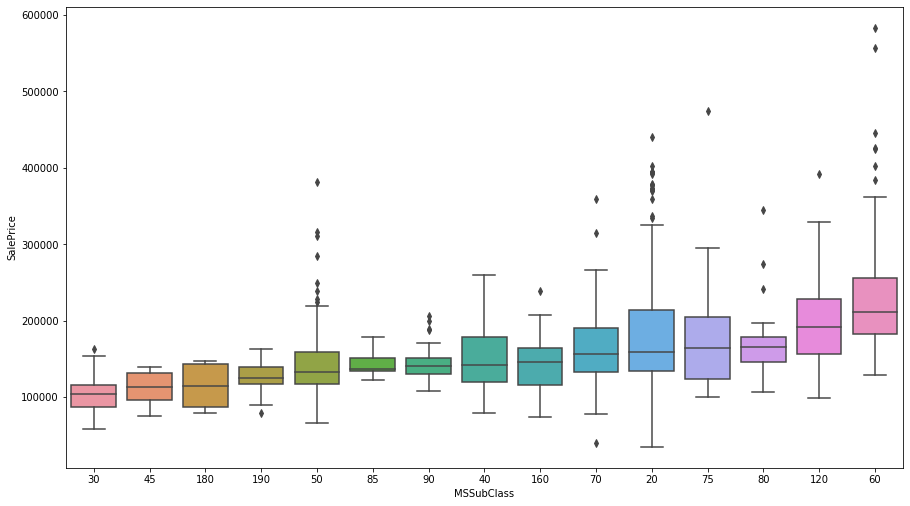

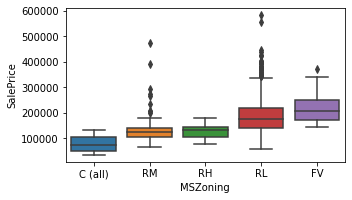

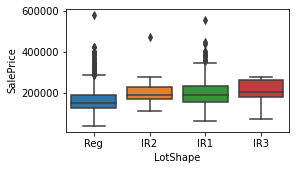

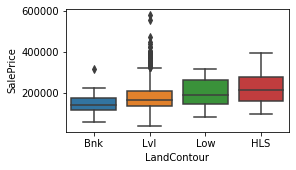

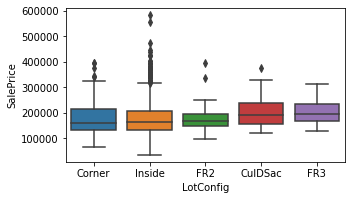

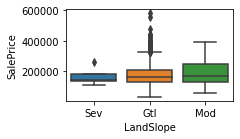

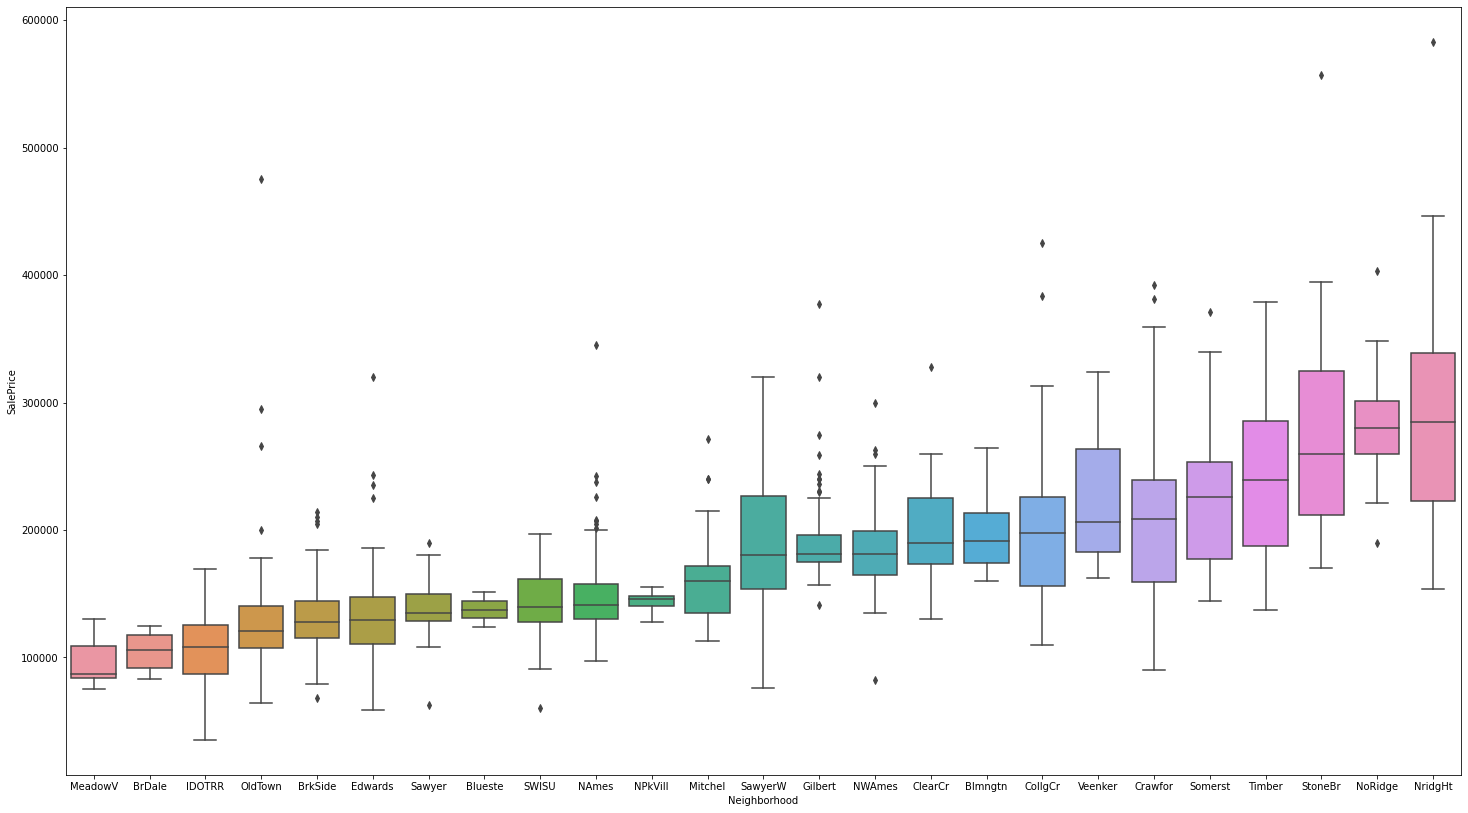

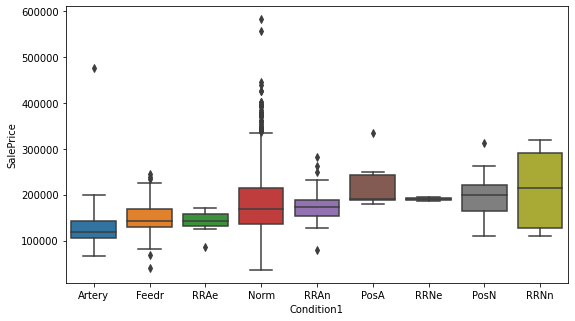

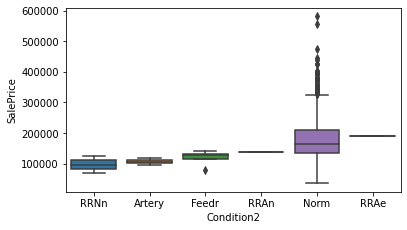

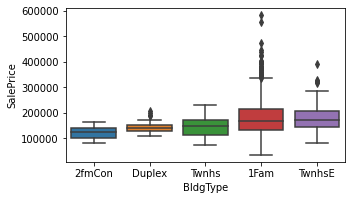

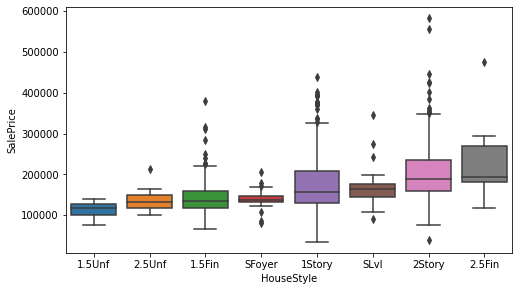

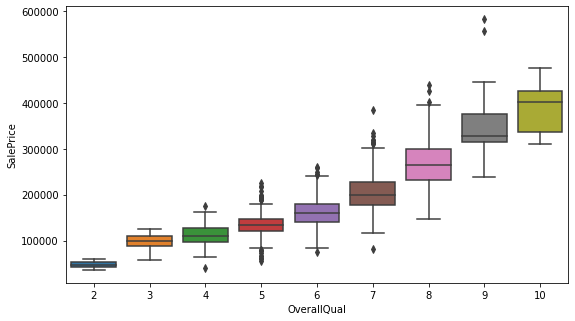

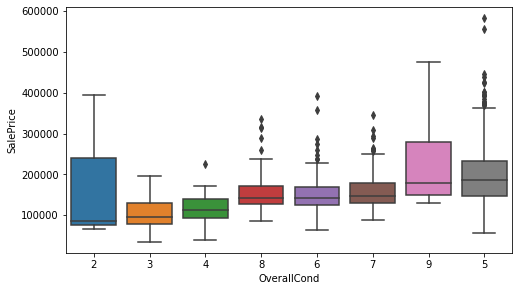

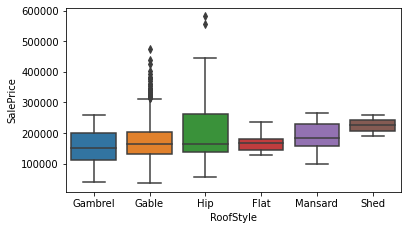

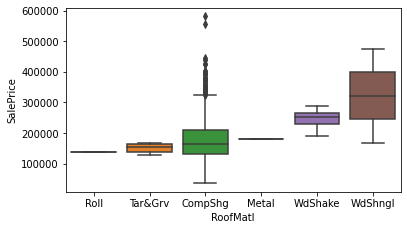

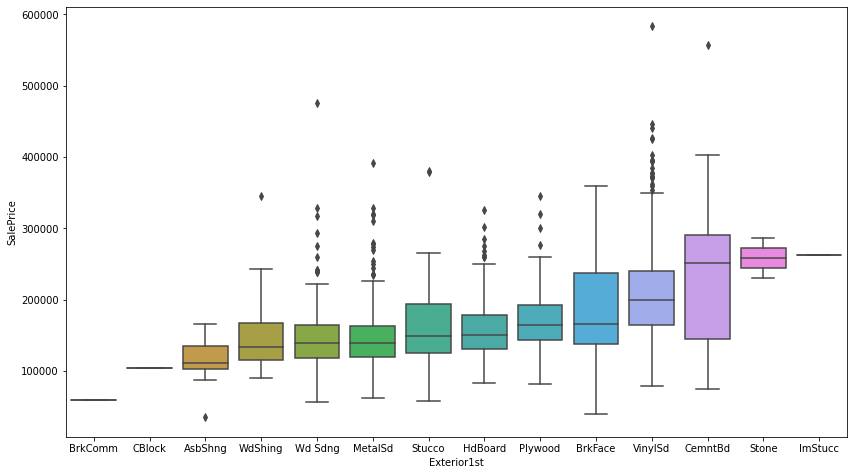

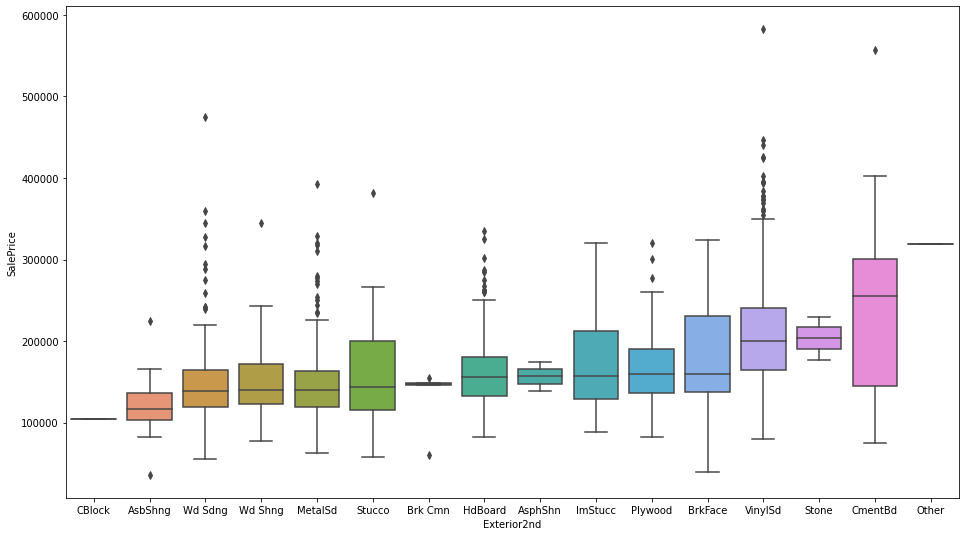

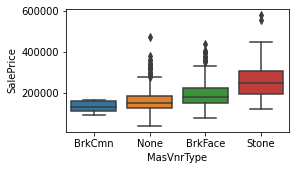

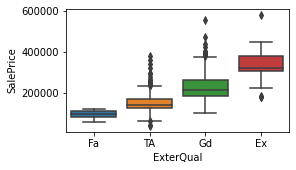

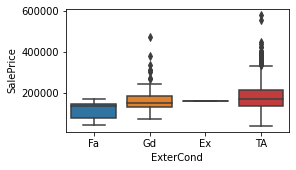

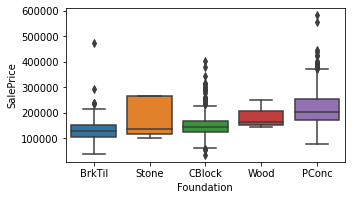

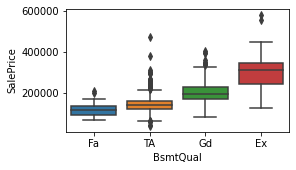

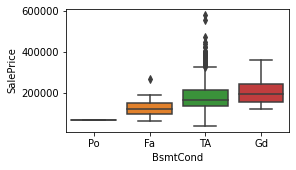

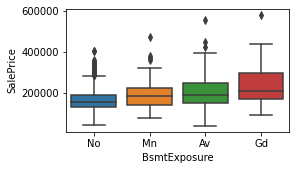

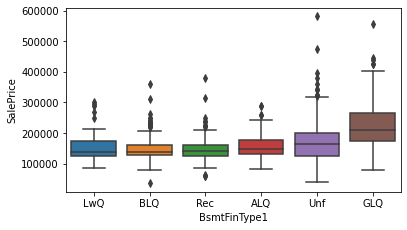

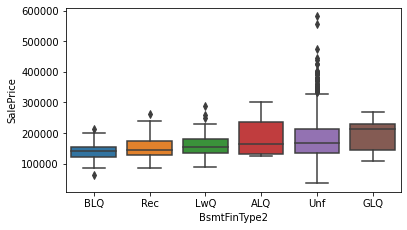

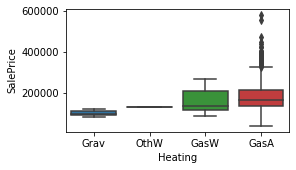

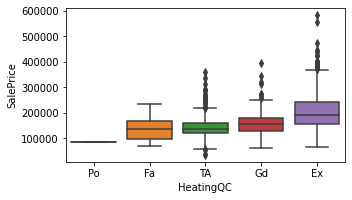

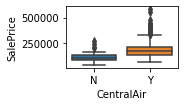

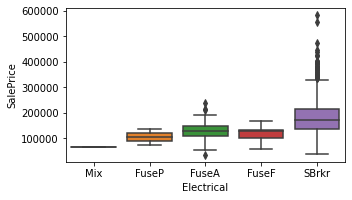

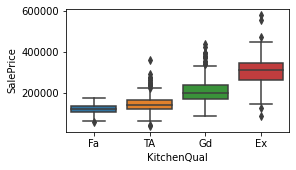

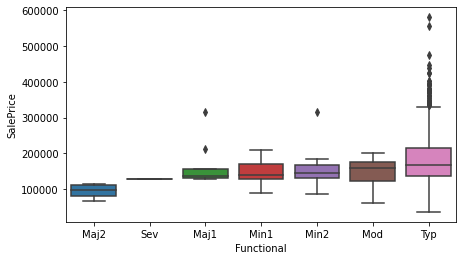

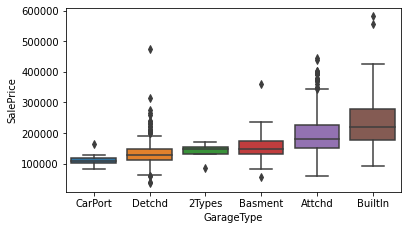

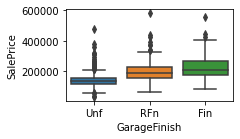

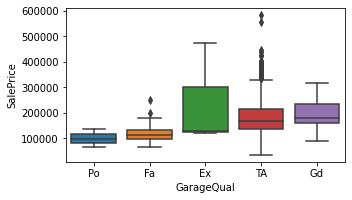

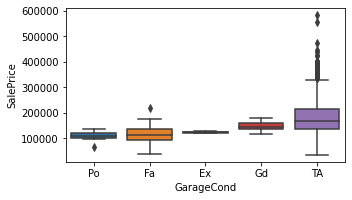

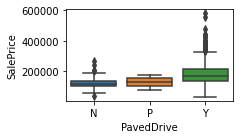

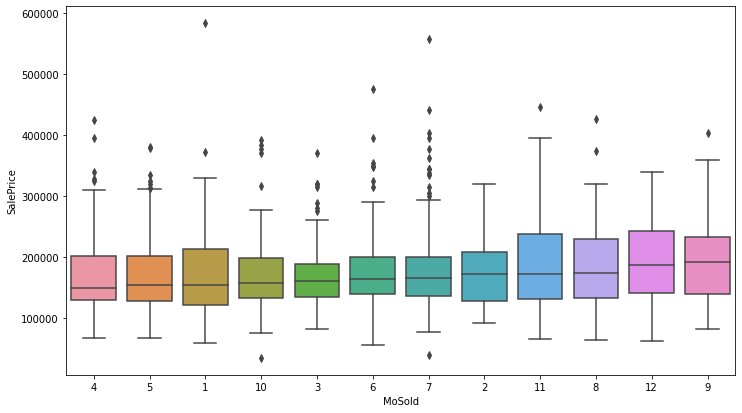

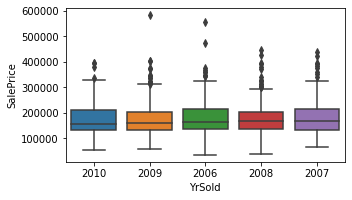

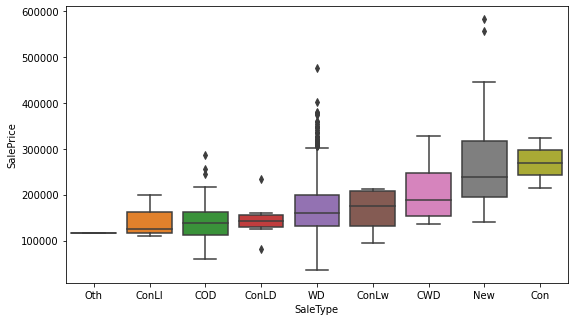

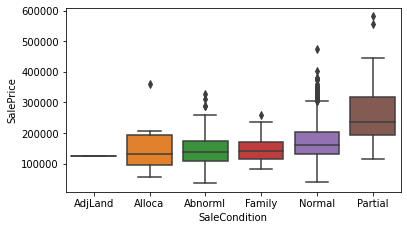

In [42]:

# CATEGORICAL COLUMN ANALYSIS
for i, col in enumerate(cat_col):
    cat_col_analysis(i, col, out_col)

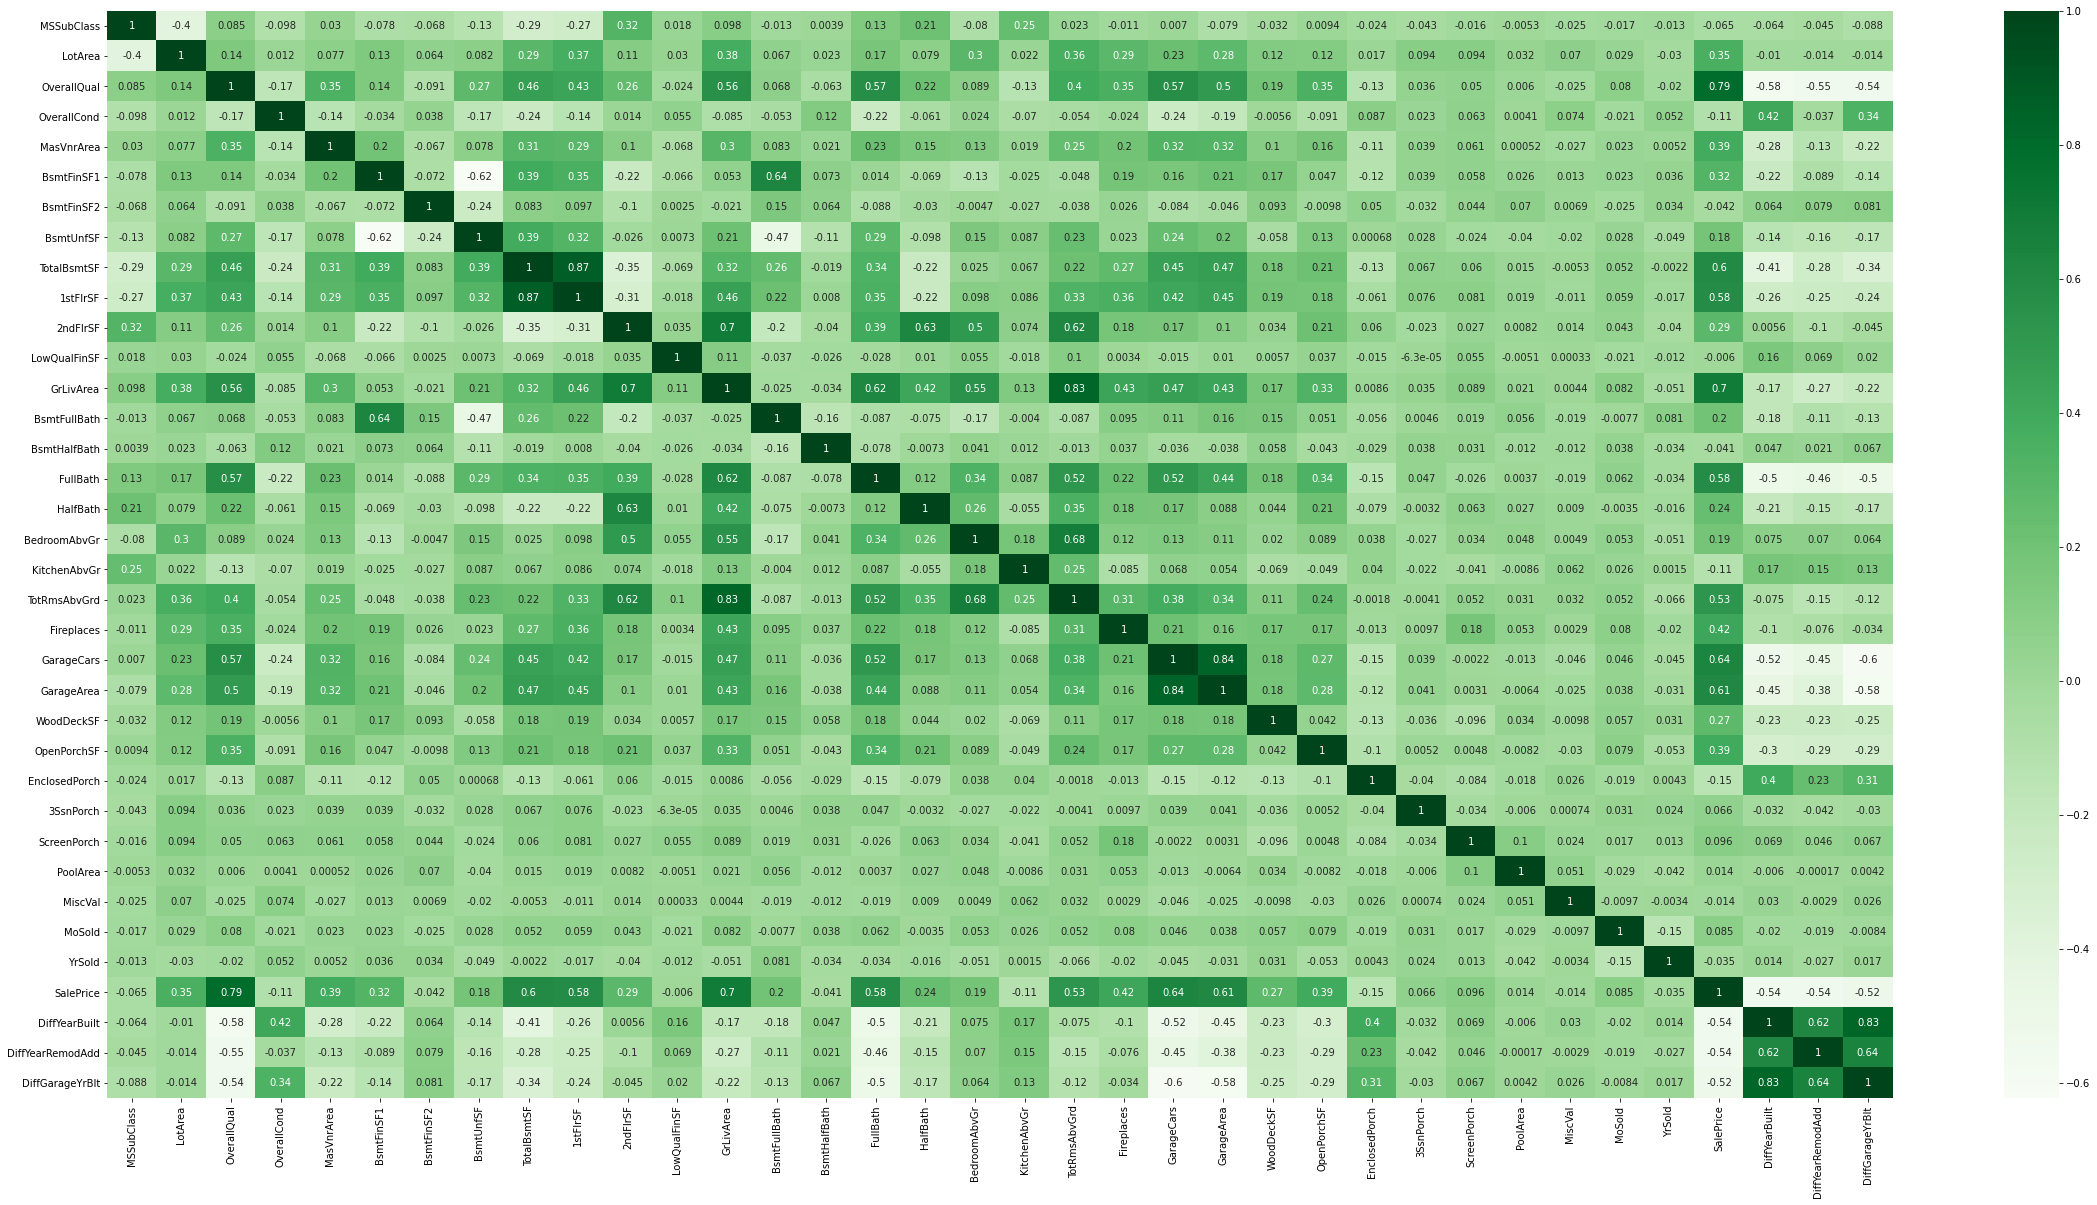

In [43]:
# Check the correlation of numerical columns

plt.figure(figsize = (40, 20))
sns.heatmap(company.corr(), annot = True, cmap="Greens")
plt.show()

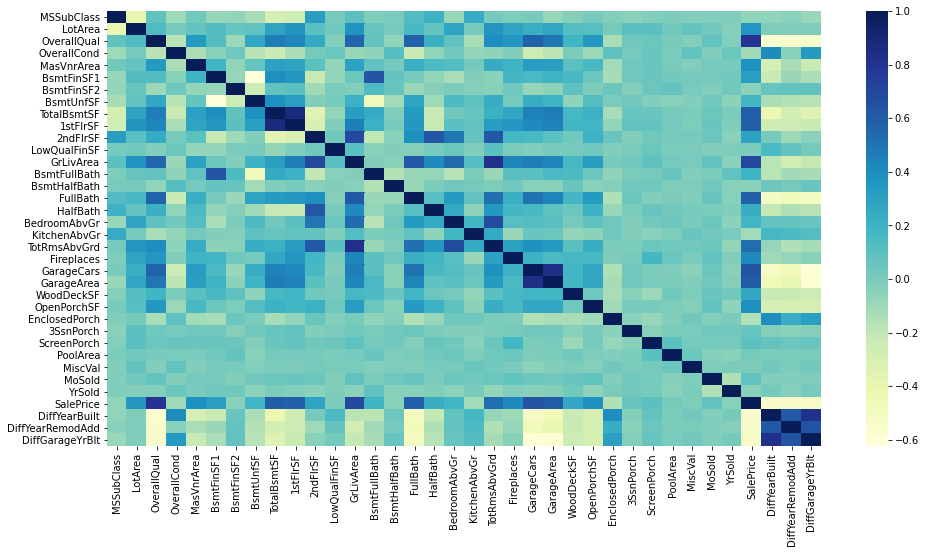

In [44]:

# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(company.corr(), cmap="YlGnBu", annot=False)
plt.show()

###### There is collinearity and that can be taken care by lasso and ridge regression too

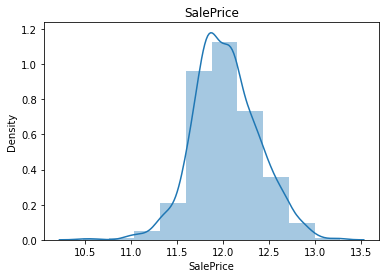

In [45]:
# Visualise the target variable -> SalePrice after transforming the sales price

company['SalePrice'] = np.log1p(company['SalePrice'])

plt.title('SalePrice')
sns.distplot(company['SalePrice'], bins=10)
plt.show()

### Step 4 Data Preperation

In [46]:
company.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,DiffYearBuilt,DiffYearRemodAdd,DiffGarageYrBlt
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,2,2008,WD,Normal,12.247699,18,18,18.0
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,0,0,5,2007,WD,Normal,12.109016,45,45,45.0
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,9,2008,WD,Normal,12.317171,20,19,20.0
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,0,0,2,2006,WD,Abnorml,11.849405,106,51,23.0
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,0,0,12,2008,WD,Normal,12.429220,21,21,21.0


In [47]:
# Creating the dummy variables and dropping the first column from these variables using 'drop_first = True'
# For the following columns create dummies

# Creating dummies for MSZoning

d_MSZoning = pd.get_dummies(company['MSZoning'], prefix='MSZoning', drop_first = True)
company = pd.concat([company, d_MSZoning], axis = 1)

# Creating dummies for Neighborhood

d_Neighborhood = pd.get_dummies(company['Neighborhood'], prefix='Neighborhood', drop_first = True)
company = pd.concat([company, d_Neighborhood], axis = 1)

# Creating dummies for RoofStyle

d_RoofStyle = pd.get_dummies(company['RoofStyle'], prefix='RoofStyle', drop_first = True)
company = pd.concat([company, d_RoofStyle], axis = 1)

# Creating dummies for Exterior1st

d_Exterior1st = pd.get_dummies(company['Exterior1st'], prefix='Exterior1st', drop_first = True)
company = pd.concat([company, d_Exterior1st], axis = 1)

# Creating dummies for Exterior2nd

d_Exterior2nd = pd.get_dummies(company['Exterior2nd'], prefix='Exterior2nd', drop_first = True)
company = pd.concat([company, d_Exterior2nd], axis = 1)

# Creating dummies for Foundation

d_Foundation = pd.get_dummies(company['Foundation'], prefix='Foundation', drop_first = True)
company = pd.concat([company, d_Foundation], axis = 1)

# Creating dummies for GarageType

d_GarageType = pd.get_dummies(company['GarageType'], prefix='GarageType', drop_first = True)
company = pd.concat([company, d_GarageType], axis = 1)

d_RoofMatl = pd.get_dummies(company['RoofMatl'], prefix='RoofMatl', drop_first = True)
company = pd.concat([company, d_RoofMatl], axis = 1)


d_Condition1= pd.get_dummies(company['Condition1'], prefix='Condition1', drop_first = True)
company = pd.concat([company, d_Condition1], axis = 1)

d_Condition2= pd.get_dummies(company['Condition2'], prefix='Condition2', drop_first = True)
company = pd.concat([company, d_Condition2], axis = 1)

d_LandContour= pd.get_dummies(company['LandContour'], prefix='LandContour', drop_first = True)
company = pd.concat([company, d_LandContour], axis = 1)

d_LandSlope= pd.get_dummies(company['LandSlope'], prefix='LandSlope', drop_first = True)
company = pd.concat([company, d_LandSlope], axis = 1)

############3
d_Functional= pd.get_dummies(company['Functional'], prefix='Functional', drop_first = True)
company = pd.concat([company, d_Functional], axis = 1)

d_Heating= pd.get_dummies(company['Heating'], prefix='Heating', drop_first = True)
company = pd.concat([company, d_Heating], axis = 1)

d_CentralAir= pd.get_dummies(company['CentralAir'], prefix='CentralAir', drop_first = True)
company = pd.concat([company, d_CentralAir], axis = 1)

d_Electrical= pd.get_dummies(company['Electrical'], prefix='Electrical', drop_first = True)
company = pd.concat([company, d_Electrical], axis = 1)

d_SaleType= pd.get_dummies(company['SaleType'], prefix='SaleType', drop_first = True)
company = pd.concat([company, d_SaleType], axis = 1)

d_PavedDrive= pd.get_dummies(company['PavedDrive'], prefix='PavedDrive', drop_first = True)
company = pd.concat([company, d_PavedDrive], axis = 1)

 

company.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,PavedDrive_P,PavedDrive_Y
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,0,0,0,0,0,0,0,1,0,1
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,0,0,0,0,0,0,0,1,0,1


In [48]:
company.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       ...
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'PavedDrive_P', 'PavedDrive_Y'],
      dtype='object', length=189)

In [49]:

# drop the below columns as we now have new columns derived from these columns

company = company.drop(['MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 
                               'GarageType', 'RoofMatl', 'Condition1', 'Condition2','LandContour', 'LandSlope','Functional','Heating','CentralAir','Electrical','SaleType','PavedDrive'], axis=1)



In [50]:

#company = company.drop(['RoofMatl', 'Condition1', 'Condition2','LandContour', 'LandSlope' ])
#company.head()

In [51]:

# Since the values of the following fields are ordered list, we shall assign values to them in sequence

# For values which can be ordered, we have given an ordered sequence value
# For values which cannot be ordered, we have categorised them into 0 and 1

company['d_LotShape'] = company['LotShape'].map({'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0})
company['d_ExterQual'] = company['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })
company['d_BsmtQual'] = company['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
company['d_BsmtExposure'] = company['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0})
company['d_BsmtFinType1'] = company['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
                                                                 'None': 0})
company['d_HeatingQC'] = company['HeatingQC'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
company['d_KitchenQual'] = company['KitchenQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
company['d_GarageFinish'] = company['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0 })
company['d_BldgType'] = company['BldgType'].map({'Twnhs': 5, 'TwnhsE': 4, 'Duplex': 3, '2fmCon': 2, '1Fam': 1, 
                                                                 'None': 0 })
company['d_HouseStyle'] = company['HouseStyle'].map({'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4, 
                                                                 '1.5Fin': 3, '1.5Unf': 2, '1Story': 1, 'None': 0 })
company['d_LotConfig'] = company['LotConfig'].map({'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 
                                                           'None': 0  })
company['d_MasVnrType'] = company['MasVnrType'].map({'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0 })
company['d_SaleCondition'] = company['SaleCondition'].map({'Normal': 1, 'Partial': 1, 'Abnorml': 0, 'Family': 0, 
                                                                   'Alloca': 0, 'AdjLand': 0, 'None': 0})



company['d_BsmtFinType2'] = company['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0})
company['d_ExterCond'] = company['ExterCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })                                                            
company['d_BsmtCond'] = company['BsmtCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })

company['d_GarageQual'] = company['GarageQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })

company['d_GarageCond'] = company['GarageCond'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0 })


company.head()

,MSSubClass,LotArea,LotShape,LotConfig,BldgType,HouseStyle,OverallQual,OverallCond,MasVnrType,MasVnrArea,...,d_BldgType,d_HouseStyle,d_LotConfig,d_MasVnrType,d_SaleCondition,d_BsmtFinType2,d_ExterCond,d_BsmtCond,d_GarageQual,d_GarageCond
0,60,8450,Reg,Inside,1Fam,2Story,7,5,BrkFace,196.0,...,1,4,5,1,1,1,3,3,3,3
1,20,9600,Reg,FR2,1Fam,1Story,6,8,None,0.0,...,1,1,2,0,1,1,3,3,3,3
2,60,11250,IR1,Inside,1Fam,2Story,7,5,BrkFace,162.0,...,1,4,5,1,1,1,3,3,3,3
3,70,9550,IR1,Corner,1Fam,2Story,7,5,None,0.0,...,1,4,4,0,0,1,3,4,3,3
4,60,14260,IR1,FR2,1Fam,2Story,8,5,BrkFace,350.0,...,1,4,2,1,1,1,3,3,3,3


In [52]:
columnsToBeRemoved

['Street', 'Utilities']

In [53]:
# drop the old columns from which the new columns were derived
# We can also drop the id column as it will not be used any more

company = company.drop(['LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 
                                'KitchenQual', 'GarageFinish', 'BldgType', 'HouseStyle', 
                                'LotConfig', 'MasVnrType', 'SaleCondition','BsmtFinType2','ExterCond','BsmtCond','GarageQual','GarageCond'], axis=1)



company.head()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,d_BldgType,d_HouseStyle,d_LotConfig,d_MasVnrType,d_SaleCondition,d_BsmtFinType2,d_ExterCond,d_BsmtCond,d_GarageQual,d_GarageCond
0,60,8450,7,5,196.0,706,0,150,856,856,...,1,4,5,1,1,1,3,3,3,3
1,20,9600,6,8,0.0,978,0,284,1262,1262,...,1,1,2,0,1,1,3,3,3,3
2,60,11250,7,5,162.0,486,0,434,920,920,...,1,4,5,1,1,1,3,3,3,3
3,70,9550,7,5,0.0,216,0,540,756,961,...,1,4,4,0,0,1,3,4,3,3
4,60,14260,8,5,350.0,655,0,490,1145,1145,...,1,4,2,1,1,1,3,3,3,3


In [54]:
#company.dtypes[company.dtypes = 'object']

###### Modeling

In [55]:
# Putting all feature variable to X

X = company.drop(['SalePrice'], axis=1)
X.head()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,d_BldgType,d_HouseStyle,d_LotConfig,d_MasVnrType,d_SaleCondition,d_BsmtFinType2,d_ExterCond,d_BsmtCond,d_GarageQual,d_GarageCond
0,60,8450,7,5,196.0,706,0,150,856,856,...,1,4,5,1,1,1,3,3,3,3
1,20,9600,6,8,0.0,978,0,284,1262,1262,...,1,1,2,0,1,1,3,3,3,3
2,60,11250,7,5,162.0,486,0,434,920,920,...,1,4,5,1,1,1,3,3,3,3
3,70,9550,7,5,0.0,216,0,540,756,961,...,1,4,4,0,0,1,3,4,3,3
4,60,14260,8,5,350.0,655,0,490,1145,1145,...,1,4,2,1,1,1,3,3,3,3


In [56]:
X.dtypes

MSSubClass          int64
LotArea             int64
OverallQual         int64
OverallCond         int64
MasVnrArea        float64
                   ...   
d_BsmtFinType2      int64
d_ExterCond         int64
d_BsmtCond          int64
d_GarageQual        int64
d_GarageCond        int64
Length: 170, dtype: object

In [57]:
# Putting response variable to y

y = company['SalePrice']
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [58]:
# scaling the features

from sklearn.preprocessing import scale

# storing column names in cols
# scaling (the dataframe is converted to a numpy array)

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'd_BldgType', 'd_HouseStyle', 'd_LotConfig', 'd_MasVnrType',
       'd_SaleCondition', 'd_BsmtFinType2', 'd_ExterCond', 'd_BsmtCond',
       'd_GarageQual', 'd_GarageCond'],
      dtype='object', length=170)

### Step 7 Test Train Split

In [59]:
# split into train and test


from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=42)

## RFE

###### We have 171 features lets try first 50 in first iteration

In [60]:
company.shape

(1245, 171)

In [61]:
# Running RFE with the output number of the variable equal to 50
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

# running RFE
rfe = RFE(lm, 50)            
rfe = rfe.fit(X_train, y_train)

In [62]:
X_train.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'd_BldgType', 'd_HouseStyle', 'd_LotConfig', 'd_MasVnrType',
       'd_SaleCondition', 'd_BsmtFinType2', 'd_ExterCond', 'd_BsmtCond',
       'd_GarageQual', 'd_GarageCond'],
      dtype='object', length=170)

In [63]:
# Assign the columns selected by RFE to cols

col = X_train.columns[rfe.support_]

# assign the 50 features selected using RFE to a dataframe and view them

temp_df = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
temp_df = temp_df.loc[temp_df['rfe_support'] == True]
temp_df.reset_index(drop=True, inplace=True)

temp_df 

,Variable,rfe_support,rfe_ranking
0,OverallQual,True,1
1,OverallCond,True,1
2,BsmtFinSF1,True,1
3,BsmtFinSF2,True,1
4,TotalBsmtSF,True,1
5,1stFlrSF,True,1
6,2ndFlrSF,True,1
7,LowQualFinSF,True,1
8,GrLivArea,True,1
9,GarageArea,True,1


In [107]:
# Assign the 50 columns to X_train_rfe

X_train_rfe = X_train[col]
# Associate the new 50 columns to X_train and X_test for further analysis

X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

In [108]:
X.dtypes

MSSubClass              float64
LotArea                 float64
OverallQual             float64
OverallCond             float64
MasVnrArea              float64
BsmtFinSF1              float64
BsmtFinSF2              float64
BsmtUnfSF               float64
TotalBsmtSF             float64
1stFlrSF                float64
2ndFlrSF                float64
LowQualFinSF            float64
GrLivArea               float64
BsmtFullBath            float64
BsmtHalfBath            float64
FullBath                float64
HalfBath                float64
BedroomAbvGr            float64
KitchenAbvGr            float64
TotRmsAbvGrd            float64
Fireplaces              float64
GarageCars              float64
GarageArea              float64
WoodDeckSF              float64
OpenPorchSF             float64
EnclosedPorch           float64
3SsnPorch               float64
ScreenPorch             float64
PoolArea                float64
MiscVal                 float64
MoSold                  float64
YrSold  

In [109]:
X_test.dtypes

OverallQual             float64
OverallCond             float64
BsmtFinSF1              float64
BsmtFinSF2              float64
TotalBsmtSF             float64
1stFlrSF                float64
2ndFlrSF                float64
LowQualFinSF            float64
GrLivArea               float64
GarageArea              float64
DiffYearBuilt           float64
MSZoning_FV             float64
MSZoning_RH             float64
MSZoning_RL             float64
MSZoning_RM             float64
Neighborhood_Crawfor    float64
RoofStyle_Shed          float64
Exterior1st_BrkFace     float64
Exterior1st_CBlock      float64
Exterior1st_CemntBd     float64
Exterior1st_HdBoard     float64
Exterior1st_ImStucc     float64
Exterior1st_MetalSd     float64
Exterior1st_Plywood     float64
Exterior1st_Stone       float64
Exterior1st_Stucco      float64
Exterior1st_VinylSd     float64
Exterior1st_Wd Sdng     float64
Exterior1st_WdShing     float64
Exterior2nd_AsphShn     float64
Exterior2nd_Brk Cmn     float64
Exterior

### Step 8 - Model Building and evaluation

In [155]:
# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [156]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
13,2,-0.081732,-0.087471,1
12,1,-0.081643,-0.087475,2
11,0.9,-0.081635,-0.087484,3
10,0.8,-0.081626,-0.087493,4
14,3,-0.081823,-0.087499,5
9,0.7,-0.081620,-0.087503,6
8,0.6,-0.081614,-0.087512,7
15,4,-0.081900,-0.087519,8
7,0.5,-0.081609,-0.087522,9
6,0.4,-0.081606,-0.087533,10


In [157]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
X_test.columns

Index(['OverallQual', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea',
       'DiffYearBuilt', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Neighborhood_Crawfor', 'RoofStyle_Shed',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing',
       'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace',
       'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other',
       'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco',
       'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng',
       'GarageType_Attchd', 'GarageType

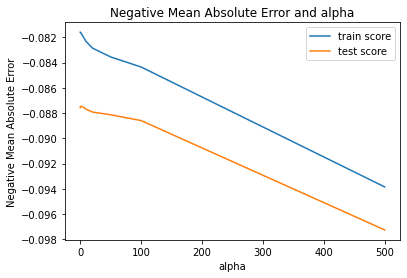

In [158]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()


In [159]:

# get the best estimator for lambda

ridge_model_cv.best_estimator_

Ridge(alpha=2.0)

In [168]:

# check the coefficient values with lambda = 2.0

alpha = 2.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 0.08976926,  0.05926133,  0.03957429,  0.00283757,  0.04853271,
        0.03798668,  0.0472643 ,  0.00169203,  0.07219719,  0.045198  ,
       -0.05465467,  0.08181068,  0.02699486,  0.14806625,  0.09860616,
        0.03226007, -0.00186393,  0.00611368, -0.00056577, -0.00613945,
        0.00593897,  0.00099734,  0.00860828, -0.01482659, -0.00428801,
        0.00462332,  0.01909105,  0.00098905,  0.00292904,  0.0016192 ,
        0.00143597,  0.00366951, -0.00056577,  0.00900213, -0.00245179,
       -0.00174311,  0.00431986,  0.00203073,  0.00610819,  0.00381463,
        0.0050572 ,  0.0092818 ,  0.0051128 ,  0.00109415,  0.1223865 ,
        0.03290234,  0.06276109,  0.09509326, -0.00263494,  0.03646865])

In [169]:
# Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

0.016013049059459557

In [170]:
y_test

860     12.154521
513     11.805603
1310    12.721889
389     12.962197
381     12.142872
1418    11.728045
1201    12.195522
92      12.004574
45      12.675767
1108    12.106258
1100    11.002117
557     11.589896
1212    11.635152
1135    11.532738
574     11.842236
245     12.394629
1227    11.898195
346     11.928348
288     11.711785
1116    12.123240
231     12.906694
1236    12.075400
1386    12.429220
541     12.421188
1457    12.493133
721     11.870607
255     12.345839
966     11.982935
1414    12.240479
424     11.842236
544     12.098855
943     11.870607
272     12.577640
199     12.524166
754     11.957618
341     11.314487
490     11.652696
611     11.904974
680     11.870607
337     12.273736
488     11.982935
315     12.146859
437     11.686887
604     12.305923
1198    12.089544
1440    12.160034
1327    11.779136
500     11.635152
1067    12.031130
493     11.951187
700     12.652363
1301    12.086732
1147    12.069686
52      11.608245
665     12.348010
347     11

In [171]:
X_test

,OverallQual,OverallCond,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,DiffYearBuilt,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Crawfor,RoofStyle_Shed,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_Detchd,Condition2_RRAe,d_BsmtQual
735,0.682605,2.202400,-1.061064,-0.293642,-0.430747,-0.673014,0.403006,-0.103702,-0.136419,-1.554041,1.843175,-0.219043,-0.094415,0.513770,-0.416439,4.888763,-0.040112,-0.177435,-0.028352,-0.189139,-0.438781,-0.028352,-0.427008,-0.277470,-0.040112,-0.124489,-0.765498,2.567385,-0.124489,-0.040112,-0.069589,-0.121119,-0.028352,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,-0.751046,2.594787,-0.157135,-1.306339,-0.124489,-0.251384,1.580250,-0.028352,-0.847524
442,-0.113874,-0.564490,-0.243874,-0.293642,0.075547,-0.178591,-0.811318,-0.103702,-0.893798,-0.028462,-0.352340,-0.219043,-0.094415,0.513770,-0.416439,-0.204551,-0.040112,-0.177435,-0.028352,-0.189139,-0.438781,-0.028352,-0.427008,-0.277470,-0.040112,-0.124489,1.306339,-0.389501,-0.124489,-0.040112,-0.069589,-0.121119,-0.028352,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,1.331476,-0.385388,-0.157135,0.765498,-0.124489,-0.251384,-0.632811,-0.028352,-0.847524
1117,0.682605,2.202400,2.358488,-0.293642,2.483385,2.240547,-0.811318,-0.103702,0.905525,0.444012,0.458311,-0.219043,-0.094415,0.513770,-0.416439,4.888763,-0.040112,5.635881,-0.028352,-0.189139,-0.438781,-0.028352,-0.427008,-0.277470,-0.040112,-0.124489,-0.765498,-0.389501,-0.124489,-0.040112,-0.069589,-0.121119,-0.028352,-0.189139,2.386116,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,-0.751046,-0.385388,-0.157135,0.765498,-0.124489,-0.251384,-0.632811,-0.028352,0.649167
333,3.072041,-0.564490,2.052042,-0.293642,1.835800,1.769669,0.582556,-0.103702,1.846777,2.032207,-1.162992,-0.219043,-0.094415,0.513770,-0.416439,-0.204551,-0.040112,-0.177435,-0.028352,-0.189139,-0.438781,-0.028352,-0.427008,-0.277470,-0.040112,-0.124489,1.306339,-0.389501,-0.124489,-0.040112,-0.069589,-0.121119,-0.028352,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,1.331476,-0.385388,-0.157135,-1.306339,-0.124489,3.977980,-0.632811,-0.028352,2.145857
327,0.682605,-0.564490,-1.061064,-0.293642,0.690752,0.471810,-0.811318,-0.103702,-0.410038,0.472474,-1.129215,4.565315,-0.094415,-1.946397,-0.416439,-0.204551,-0.040112,-0.177435,-0.028352,-0.189139,-0.438781,-0.028352,-0.427008,-0.277470,-0.040112,-0.124489,1.306339,-0.389501,-0.124489,-0.040112,-0.069589,-0.121119,-0.028352,-0.189139,-0.419091,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,1.331476,-0.385388,-0.157135,0.765498,-0.124489,-0.251384,-0.632811,-0.028352,0.649167
1209,-0.910353,-0.564490,-1.000261,5.109025,0.252161,0.009760,-0.811318,-0.103702,-0.753705,-0.870946,0.323203,-0.219043,-0.094415,0.513770,-0.416439,-0.204551,-0.040112,-0.177435,-0.028352,-0.189139,2.279041,-0.028352,-0.427008,-0.277470,-0.040112,-0.124489,-0.765498,-0.389501,-0.124489,-0.040112,-0.069589,-0.121119,-0.028352,-0.189139,2.386116,-0.080419,-0.421737,-0.028352,-0.315948,-0.040112,-0.130984,-0.751046,-0.385388,-0.157135,-1.306339,-0.124489,-0.251384,1.580250,-0.028352,-0.847524
1026,0.682605,-0.564490,-1.061064,-0.293642,-0.566151,-0.808391,1.345644,-0.103702,0.636283,0.324470,-0.858998,-0.219043,-0.094415,0.513770,-0.416439,-0.204551,-0.040112,-0.177435,-0.028352,-

In [172]:
ridge.predict(X_test)

array([12.06505637, 11.90168243, 12.7445197 , 12.96020211, 12.17715962,
       11.67368318, 12.19641482, 11.92198482, 12.55495254, 12.09154634,
       11.06321927, 11.11248003, 11.48032109, 11.47256287, 11.79146298,
       12.4066452 , 11.8965012 , 11.91779833, 11.61560384, 12.153728  ,
       12.75558628, 12.13095153, 12.49949806, 12.46092349, 12.51936359,
       11.82720762, 12.3337085 , 11.91913772, 11.92598812, 11.89183661,
       12.12699337, 11.94307437, 12.63498797, 12.62136517, 11.88555443,
       11.0602108 , 11.68153558, 11.97816449, 11.75560583, 12.30842677,
       11.96370949, 12.10403226, 11.54889247, 12.30135911, 12.105456  ,
       12.42186108, 11.91019416, 11.62769214, 11.99497658, 11.83631172,
       12.64806624, 12.07637578, 12.15231242, 11.35603663, 12.38036483,
       12.0756791 , 11.6398881 , 11.79578673, 12.29887394, 12.24640469,
       11.62017848, 12.02706017, 12.26956742, 11.55167419, 11.60654625,
       11.5795971 , 11.94971877, 11.32152793, 11.97070568, 11.96

In [173]:
y_pred_1 = ridge.predict(X_test)

In [174]:
rig_1 = r2_score(y_test,y_pred_1)
rig_1

0.862561124062498

In [175]:

# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

,Features,Coefficient
0,OverallQual,0.0898
1,OverallCond,0.0593
2,BsmtFinSF1,0.0396
3,BsmtFinSF2,0.0028
4,TotalBsmtSF,0.0485
5,1stFlrSF,0.0380
6,2ndFlrSF,0.0473
7,LowQualFinSF,0.0017
8,GrLivArea,0.0722
9,GarageArea,0.0452


In [176]:

# Do an RFE to minimise the features to 20
X_train_ridge = X_train[ridge_df.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm, 20)            
rfe = rfe.fit(X_train_ridge, y_train)

In [177]:
# Assign the Features and their coefficient values to a dictionary which would be used while plotting the bar plot

ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(4), index = X_train.columns))
ridge_coeff_dict



# Method to get the coefficient values

def find(x):
    return ridge_coeff_dict[x]

# Assign top 20 features to a temp dataframe for further display in the bar plot

temp1_df = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp1_df = temp1_df.loc[temp1_df['rfe_support'] == True]
temp1_df.reset_index(drop=True, inplace=True)

temp1_df['Coefficient'] = temp1_df['Features'].apply(find)
temp1_df = temp1_df.sort_values(by=['Coefficient'], ascending=False)
temp1_df = temp1_df.head(10)
temp1_df

,Features,rfe_support,rfe_ranking,Coefficient
11,MSZoning_RL,True,1,0.1481
15,GarageType_Attchd,True,1,0.1224
12,MSZoning_RM,True,1,0.0986
18,GarageType_Detchd,True,1,0.0951
0,OverallQual,True,1,0.0898
9,MSZoning_FV,True,1,0.0818
6,GrLivArea,True,1,0.0722
17,GarageType_BuiltIn,True,1,0.0628
1,OverallCond,True,1,0.0593
3,TotalBsmtSF,True,1,0.0485


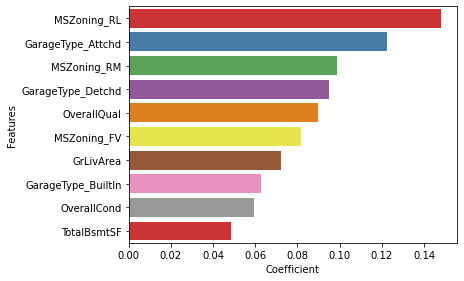

In [178]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp1_df)
plt.show()

###### Lasso

In [203]:

lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [204]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
3,0.0004,-0.082046,-0.087133,1
4,0.0005,-0.082245,-0.087134,2
2,0.0003,-0.081894,-0.087145,3
1,0.0002,-0.081764,-0.087176,4
0,0.0001,-0.081663,-0.087345,5
5,0.001,-0.083205,-0.087382,6
6,0.002,-0.084231,-0.087423,7
7,0.003,-0.084735,-0.087470,8
8,0.004,-0.085150,-0.087711,9
9,0.005,-0.085502,-0.087896,10


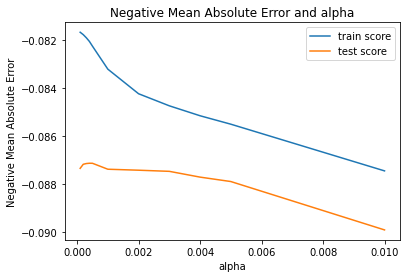

In [205]:
# plotting mean test and train scoes with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [206]:

# get the best estimator for lambda

lasso_model_cv.best_estimator_

Lasso(alpha=0.0004)

In [183]:
# check the coefficient values with lambda = 0.0004

alpha = 0.0004

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([ 9.12555202e-02,  5.94451285e-02,  3.92366904e-02,  2.18163551e-03,
        4.82239304e-02,  0.00000000e+00,  0.00000000e+00, -2.19055736e-03,
        1.22412175e-01,  4.45584223e-02, -5.56312590e-02,  7.63065221e-02,
        2.37586646e-02,  1.37974711e-01,  8.93297991e-02,  3.19220503e-02,
       -0.00000000e+00,  5.19821705e-03, -1.33447472e-03, -7.18712633e-04,
        0.00000000e+00,  2.30287299e-04,  4.80231635e-03, -1.61254226e-02,
       -4.14485258e-03,  3.93304213e-03,  1.52899657e-02, -4.86942996e-04,
        1.13948841e-03,  8.50545968e-04,  0.00000000e+00,  1.31727300e-03,
       -3.41500592e-05,  0.00000000e+00, -4.24480069e-03, -2.09944743e-03,
        0.00000000e+00,  1.36666704e-03,  1.34252165e-03,  2.84410032e-03,
        3.14578374e-03,  2.32348646e-03, -0.00000000e+00, -2.31468320e-04,
        9.42091537e-02,  2.50047125e-02,  4.84449423e-02,  6.82759833e-02,
       -3.47550661e-03,  3.56834352e-02])

In [184]:

# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

0.01538289599197509

In [185]:
y_pred_2 = lasso.predict(X_test)

In [186]:
laso_1 = r2_score(y_test,y_pred_2)
laso_1

0.8679696836030354

In [187]:

# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,OverallQual,0.0913
1,OverallCond,0.0594
2,BsmtFinSF1,0.0392
3,BsmtFinSF2,0.0022
4,TotalBsmtSF,0.0482
5,LowQualFinSF,-0.0022
6,GrLivArea,0.1224
7,GarageArea,0.0446
8,DiffYearBuilt,-0.0556
9,MSZoning_FV,0.0763


In [135]:
# Put the Features and Coefficients in dictionary

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'OverallQual': 0.09184453312081006,
 'OverallCond': 0.059556421936997346,
 'BsmtFinSF1': 0.03923480835337765,
 'BsmtFinSF2': 0.0019629927650115183,
 'TotalBsmtSF': 0.04812060263564641,
 '1stFlrSF': 0.0,
 '2ndFlrSF': 0.0,
 'LowQualFinSF': -0.001992372958222595,
 'GrLivArea': 0.12211642311280957,
 'GarageArea': 0.04417854789910283,
 'DiffYearBuilt': -0.055863444928905784,
 'MSZoning_FV': 0.07258729168539535,
 'MSZoning_RH': 0.021683139426127096,
 'MSZoning_RL': 0.13088130020709482,
 'MSZoning_RM': 0.08303626863549848,
 'Neighborhood_Crawfor': 0.03170992616948009,
 'RoofStyle_Shed': -0.0,
 'Exterior1st_BrkFace': 0.005213784582464503,
 'Exterior1st_CBlock': -0.0012584155937218255,
 'Exterior1st_CemntBd': -0.0007173370082630491,
 'Exterior1st_HdBoard': 0.0,
 'Exterior1st_ImStucc': 0.00010945377336836311,
 'Exterior1st_MetalSd': 0.00426361234181125,
 'Exterior1st_Plywood': -0.015969811148974826,
 'Exterior1st_Stone': -0.0039769306601935926,
 'Exterior1st_Stucco': 0.0036616749686961014,
 'Ex

###### RFE

In [188]:

# Do an RFE to minimise the features to 15

X_train_lasso = X_train[lasso_df.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE

rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_lasso, y_train)

In [189]:
# Method to get the coefficient values

def find(x):
    return lasso_coeff_dict[x]

# Assign top 10 features to a temp dataframe for further display in the bar plot

temp2_df = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
temp2_df = temp2_df.loc[temp2_df['rfe_support'] == True]
temp2_df.reset_index(drop=True, inplace=True)

temp2_df['Coefficient'] = temp2_df['Features'].apply(find)
temp2_df = temp2_df.sort_values(by=['Coefficient'], ascending=False)
temp2_df = temp2_df.head(10)
temp2_df

,Features,rfe_support,rfe_ranking,Coefficient
8,MSZoning_RL,True,1,0.130881
4,GrLivArea,True,1,0.122116
0,OverallQual,True,1,0.091845
9,MSZoning_RM,True,1,0.083036
11,GarageType_Attchd,True,1,0.078976
7,MSZoning_FV,True,1,0.072587
1,OverallCond,True,1,0.059556
14,GarageType_Detchd,True,1,0.053860
3,TotalBsmtSF,True,1,0.048121
5,GarageArea,True,1,0.044179


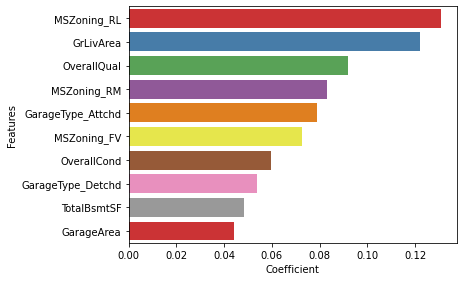

In [190]:
# bar plot to determine the variables that would affect pricing most using ridge regression

plt.figure(figsize=(20,20))
plt.subplot(4,3,1)
sns.barplot(y = 'Features', x='Coefficient', palette='Set1', data = temp2_df)
plt.show()

## Conclusion


#### The factors that generally affect the price are :
- Zoning classification
- Living area square feet
- overall material and finish of the house
- Garage location
- overall condition of the house and GarageArea 

###### Using Laso, we are able to describe the price of house with RMSE = 0.015 , R square - 0.86 ( we have chosen laso since for same variance explained we have got better R square value) 
- for Ridge Rsquare = .86, RMSE = 0.016
- for lasso , Rsquare = .86 , RMSE = 0.015


# Part 2 

###### Question 1

###### What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

In [191]:
# check the coefficient values with lambda = 20 * 2

alpha = 4
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_


# Check the mean squared error

a = mean_squared_error(y_test, ridge.predict(X_test))

print("The mean square error is",a)

b = r2_score(y_test, ridge.predict(X_test))

print("The R square for double value of alpha ",b)

# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df


The mean square error is 0.01562793445242458
The R square for double value of alpha  0.8658665356990615


,Features,Coefficient
0,OverallQual,0.0905
1,OverallCond,0.0595
2,BsmtFinSF1,0.0396
3,BsmtFinSF2,0.0028
4,TotalBsmtSF,0.0480
5,1stFlrSF,0.0382
6,2ndFlrSF,0.0469
7,LowQualFinSF,0.0018
8,GrLivArea,0.0721
9,GarageArea,0.0445


In [192]:
r2_score(y_test, lasso.predict(X_test))

0.8679696836030354

In [196]:
# check the coefficient values with lambda = 0.0005

alpha = 0.0004 * 2

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 
lasso.coef_

array([ 9.36727222e-02,  5.98783090e-02,  3.91979441e-02,  1.29467969e-03,
        4.76863823e-02,  5.46355165e-05,  0.00000000e+00, -1.44333007e-03,
        1.21184833e-01,  4.29699179e-02, -5.65542980e-02,  6.13619972e-02,
        1.54347845e-02,  1.09486282e-01,  6.40978751e-02,  3.10835751e-02,
       -0.00000000e+00,  5.39059592e-03, -1.00542851e-03, -3.58226398e-04,
        0.00000000e+00,  0.00000000e+00,  3.30859394e-03, -1.59223650e-02,
       -3.45577066e-03,  3.14778670e-03,  1.56664577e-02, -1.83341108e-04,
        5.10115388e-04,  2.44704074e-04,  0.00000000e+00,  2.28308771e-04,
       -1.37381157e-05, -0.00000000e+00, -4.44680287e-03, -1.83319502e-03,
        0.00000000e+00,  1.03137338e-03,  0.00000000e+00,  2.37150089e-03,
        3.75549810e-03,  8.66250778e-04, -0.00000000e+00, -0.00000000e+00,
        3.35256295e-02,  9.31304307e-03,  1.83565289e-02,  1.09021520e-02,
       -2.85554644e-03,  3.46021771e-02])

In [197]:
# Check the mean squared error

mean_squared_error(y_test, lasso.predict(X_test))

0.014772552401078994

In [198]:
c = r2_score(y_test, lasso.predict(X_test))

print("The R square for double value of alpha for lasso",c)

The R square for double value of alpha for lasso 0.8732082197966695


In [144]:
# Put the shortlisted Features and coefficienst in a dataframe

lasso_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
lasso_df = lasso_df[lasso_df['Coefficient'] != 0.00]
lasso_df.reset_index(drop=True, inplace=True)
lasso_df

,Features,Coefficient
0,OverallQual,0.0946
1,OverallCond,0.0600
2,BsmtFinSF1,0.0391
3,BsmtFinSF2,0.0010
4,TotalBsmtSF,0.0472
5,1stFlrSF,0.0004
6,LowQualFinSF,-0.0011
7,GrLivArea,0.1208
8,GarageArea,0.0423
9,DiffYearBuilt,-0.0571


######  we have got better R Square value and RMSE value and coefficients are changed when we double the alpha values. Same is explained in pdf too

###### Question 2

###### You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why? explained in pdf

### Question 3

### After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now? - For this attach one more python notebook plus explained in pdf too

###### Question 4

###### How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why? Explained in pdf 